[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/agent-memory.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239417-lesson-7-agent-with-memory)

# 一个 Production ready 的 LLM 应用需要什么？

![](https://s.secrss.com/anquanneican/88aacf0eb55aec6f6e490af27c7fb41f.jpg)

- 可解释性：面向 workflow 的开发如何确保可解释，让所有人理解流程里发生了什么？
- 可依赖性：如何 Debug，测试和监控，确保 LLM 应用的表现稳定？
- 可控制性：如何精细控制流程，让 LLM 应用可以更好的与人类协作？
- 并行开发：如何拆分任务，让多人合作完成开发？

In [60]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt tavily-python pygraphviz

# 什么是 Graph?
 - Node
 - Edge
 - Conditional Edge
 - State

![Screenshot 2024-08-21 at 9.24.09 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac6543c3d4df239a4ed1_router1.png)

![image](https://miro.medium.com/v2/resize:fit:809/1*RgNdI_eu8Hfu4fSL9p6BFQ.png)

![](https://media.beehiiv.com/cdn-cgi/image/fit=scale-down,format=auto,onerror=redirect,quality=80/uploads/asset/file/27562e9e-e284-439d-b6cb-5996e2f2baa9/image.png?t=1714763681)

![image](https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2024/12/16/Multi-agent-orchestration-and-reasoning.png)

In [61]:
from typing_extensions import TypedDict

class State(TypedDict):
    graph_state: str

In [62]:
def node_1(state):
    print("---Node 1---")
    return {"graph_state": state['graph_state'] +" I am"}

def node_2(state):
    print("---Node 2---")
    return {"graph_state": state['graph_state'] +" happy!"}

def node_3(state):
    print("---Node 3---")
    return {"graph_state": state['graph_state'] +" sad!"}

In [63]:
import random
from typing import Literal

def decide_mood(state) -> Literal["node_2", "node_3"]:
    
    # Often, we will use state to decide on the next node to visit
    user_input = state['graph_state'] 
    
    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"
    
    # 50% of the time, we return Node 3
    return "node_3"

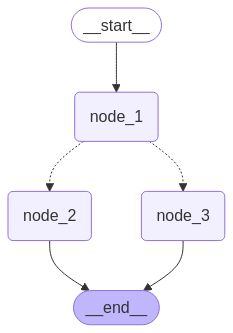

In [64]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [67]:
graph.invoke({"graph_state" : "Hi, this is YQ."})

---Node 1---
---Node 2---


{'graph_state': 'Hi, this is YQ. I am happy!'}

# LangGraph 构建的简单 Agent

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [69]:
from langchain_core.tools import tool
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b
@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
tools_by_name = {}
for tool_ in tools:
    tools_by_name[tool_.name] = tool_
print(tools_by_name)

{'add': StructuredTool(name='add', description='Adds a and b.\n\n    Args:\n        a: first int\n        b: second int', args_schema=<class 'langchain_core.utils.pydantic.add'>, func=<function add at 0x119d837e0>), 'multiply': StructuredTool(name='multiply', description='Multiply a and b.\n\n    Args:\n        a: first int\n        b: second int', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x118cbc9a0>), 'divide': StructuredTool(name='divide', description='Divide a and b.\n\n    Args:\n        a: first int\n        b: second int', args_schema=<class 'langchain_core.utils.pydantic.divide'>, func=<function divide at 0x119d81620>)}


In [70]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import BaseTool

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


def tools_node(state: MessagesState):
   tool_calls = state["messages"][-1].tool_calls
   results = []

   for t in tool_calls:
      result = tools_by_name[t["name"]].invoke(t["args"])

      message = ToolMessage(
            content=str(result), tool_call_id=t["id"], name=t["name"]
      )
      results.append(message)
   return {"messages": results}

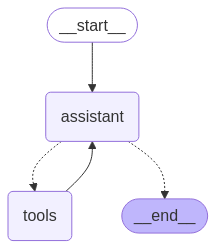

In [71]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", tools_node)

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [72]:
messages = [HumanMessage(content="Add 3 and 4.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_0cvQaUir6r8ANxkaNwRW5oW3)
 Call ID: call_0cvQaUir6r8ANxkaNwRW5oW3
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


## Memory

先跑一下之前的例子

In [73]:
messages = [HumanMessage(content="Add 3 and 4.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_ATaot5dlwtFuY9KsO8gzCWYh)
 Call ID: call_ATaot5dlwtFuY9KsO8gzCWYh
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


在原来结果上乘以 2!

In [74]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================

It seems like there is no specific number mentioned for the multiplication. Could you please provide a number to multiply by 2?


In [75]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

In [76]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_S6ckhFoSQjSaA26zYoIFlhOX)
 Call ID: call_S6ckhFoSQjSaA26zYoIFlhOX
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [77]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_S6ckhFoSQjSaA26zYoIFlhOX)
 Call ID: call_S6ckhFoSQjSaA26zYoIFlhOX
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_M2PeRqv2aJErg5Rro1ndpZxG)
 Call ID: call_M2PeRqv2aJErg5Rro1ndpZxG
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

The result of multipl

# Human In Loop

In [78]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "66"}}

for event in react_graph.stream(initial_input, thread, stream_mode="values"):
    print('message:')
    event['messages'][-1].pretty_print()

message:
================================ Human Message =================================

Multiply 2 and 3
message:
================================== Ai Message ==================================
Tool Calls:
  multiply (call_USURgkp3WVnZn4SJ3afge4Tx)
 Call ID: call_USURgkp3WVnZn4SJ3afge4Tx
  Args:
    a: 2
    b: 3
message:
================================= Tool Message =================================
Name: multiply

6
message:
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


In [79]:
# Node
def confirm(state: MessagesState):
   # System message
   sys_msg = SystemMessage(content="What ever user asked, you should confirm it by a rhetorical question.")

   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

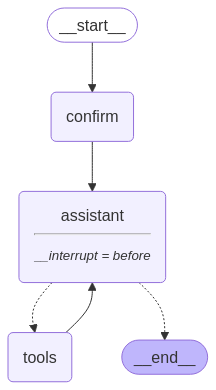

In [80]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("confirm", confirm)
builder.add_node("tools", tools_node)

# Define edges: these determine how the control flow moves
builder.add_edge(START, "confirm")
builder.add_edge("confirm", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()

graph_with_breakpoint = builder.compile(interrupt_before=["assistant"], checkpointer=memory)


# Show
display(Image(graph_with_breakpoint.get_graph(xray=True).draw_mermaid_png()))

In [81]:

# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}


# Thread
thread = {"configurable": {"thread_id": "65"}}

# Run the graph until the first interruption
for event in graph_with_breakpoint.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================

Do you want to know the result of multiplying 2 and 3?


In [82]:
state = graph_with_breakpoint.get_state(thread)
state.next

('assistant',)

In [83]:
state = graph_with_breakpoint.get_state(thread).values
for m in state['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================

Do you want to know the result of multiplying 2 and 3?


In [84]:
graph_with_breakpoint.update_state(
    thread,
    {"messages": [HumanMessage(content="No, I want to get result of 2 add 8")]},
)

new_state = graph_with_breakpoint.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================

Do you want to know the result of multiplying 2 and 3?
================================ Human Message =================================

No, I want to get result of 2 add 8


In [85]:
for event in graph_with_breakpoint.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, I want to get result of 2 add 8
================================== Ai Message ==================================
Tool Calls:
  multiply (call_zT7hCKyaKiuX1ILqjPHE81A2)
 Call ID: call_zT7hCKyaKiuX1ILqjPHE81A2
  Args:
    a: 2
    b: 3
  add (call_5EtgUqhd9BFaXriOxoekkASP)
 Call ID: call_5EtgUqhd9BFaXriOxoekkASP
  Args:
    a: 2
    b: 8
================================= Tool Message =================================
Name: add

10


In [86]:
for event in graph_with_breakpoint.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: add

10
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6, and the result of adding 2 and 8 is 10.


# 实际的例子

Goal: 作为一个运维人员，当系统出现问题发出报警日志的时候，我想要能快速定位到问题的根源，并且能快速的修复问题。
- 当报警日志发出的时候，可以总结调用链，并做出根因分析的建议，而不用我自己去翻看日志
- 当我询问这个问题的时候，能自动上网搜索相关的解决方案，而不用我自己搜索
- 当我发出指令的时候，可以自动执行相关的操作进行修复
- 自动执行修复操作的时候，需要我的 review 和确认

In [87]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python

In [88]:
import os
import getpass
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")
_set_env("OPENAI_API_KEY")

In [89]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

In [90]:
alert_log="""
2025-04-07 14:32:17.521 [INFO] [http-nio-8080-exec-45]
com.example.api.PaymentController - 
[UserAction] Received payment request: userId=U123094, amount=¥289.00, method=WeChatPay, clientIp=223.91.**.**

2025-04-07 14:32:17.529 [DEBUG] [TransactionProcessor-Worker-14]
com.example.payment.transaction.TransactionService - 
[InitTransaction] Initializing transaction for userId=U123094, cartId=C94833012

2025-04-07 14:32:17.539 [INFO] [TransactionProcessor-Worker-14]
com.example.payment.repository.TransactionRepository - 
[DB_WRITE] Inserting new transaction record: TXN-202504071432-889331245 into `payment_transaction` table

2025-04-07 14:32:17.552 [DEBUG] [HikariCP-ConnectionPool-1]
com.zaxxer.hikari.pool.HikariPool - 
[DB_POOL] Connection acquired in 4ms, thread=TransactionProcessor-Worker-14

2025-04-07 14:32:17.575 [INFO] [TransactionProcessor-Worker-14]
com.example.payment.gateway.ExternalGatewayClient - 
[GatewayRequest] Sending payment initiation to WeChatPay:
  URL: https://api.wechatpay.cn/v1/payments
  Method: POST
  Payload: {
    "transaction_id": "TXN-202504071432-889331245",
    "amount": 28900,
    "currency": "CNY",
    "user_id": "U123094"
  }
  Headers: Authorization: Bearer ***

2025-04-07 14:32:22.824 [ERROR] [TransactionProcessor-Worker-14]
com.example.payment.gateway.ExternalGatewayClient - 
[Timeout] No response from WeChatPay gateway within 5000ms (requestId=GW-REQ-202504071432-1988301)

2025-04-07 14:32:22.825 [WARN] [TransactionProcessor-Worker-14]
com.example.payment.transaction.TransactionProcessor - 
[TransactionFailed] External payment initiation failed, retrying (attempt 1/3)

2025-04-07 14:32:28.014 [ERROR] [TransactionProcessor-Worker-14]
com.example.payment.transaction.TransactionProcessor - 
[TXN_PROC_503_TIMEOUT] Payment failed after 3 retries. Marking transaction as FAILED.
TransactionId=TXN-202504071432-889331245, Error=ExternalGatewayTimeoutException

2025-04-07 14:32:28.019 [INFO] [TransactionProcessor-Worker-14]
com.example.payment.repository.TransactionRepository - 
[DB_UPDATE] Updating transaction status to FAILED for TXN-202504071432-889331245

2025-04-07 14:32:28.024 [INFO] [http-nio-8080-exec-45]
com.example.api.PaymentController - 
[Response] Returning failure response to client:
  {
    "status": "failed",
    "message": "支付请求超时，请稍后重试。",
    "errorCode": "TXN_PROC_503_TIMEOUT"
  }
""".strip()

In [91]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0.0)


In [92]:
# !pip install pygraphviz

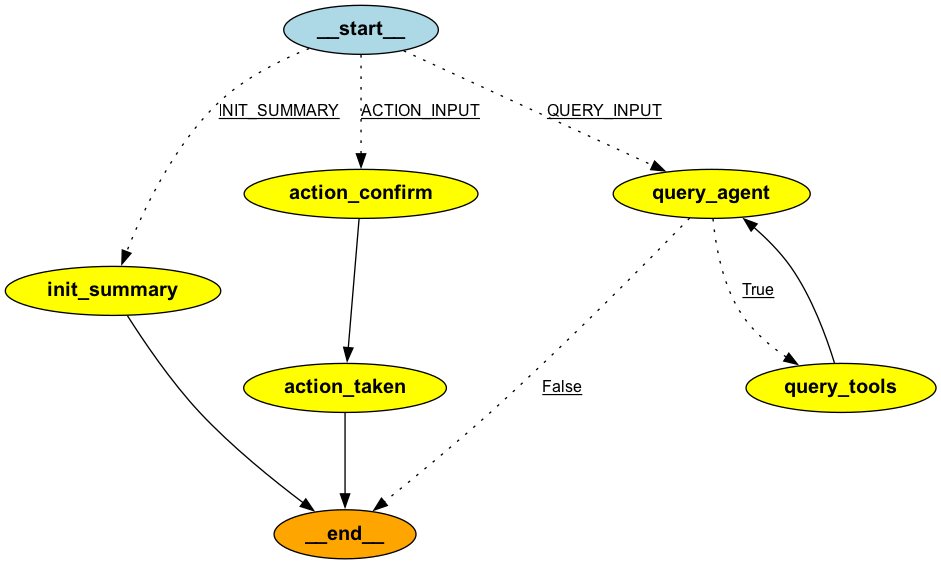

In [94]:

from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import (
    HumanMessage,
    ToolMessage,
    AIMessage,
    SystemMessage
)
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START, END, MessagesState
from IPython.display import Image, display


@tool
def search_web(query: str):
    """Retrieve docs from web search

    Args:
        query: the question to search
    """

    # Search
    tavily_search = TavilySearchResults(max_results=3)

    # Search query

    # Search
    search_docs = tavily_search.invoke(query)

    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return formatted_search_docs


from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")


class AgentState(MessagesState):
    log: str
    summary: str

class InputState(MessagesState):
    log: str


class Agent:
    def __init__(self):
        graph = StateGraph(AgentState, input=InputState, output=MessagesState)
        self.tools = [search_web]

        graph.add_node("init_summary", self.init_summary_node)
        graph.add_node("action_confirm", self.action_confirm_node)
        graph.add_node("query_agent", self.query_agent_node)
        graph.add_node("query_tools", self.query_tools_node)
        graph.add_node("action_taken", self.action_taken_node)

        graph.add_conditional_edges(
            START,
            self.is_action,
            {
                "ACTION_INPUT": "action_confirm",
                "QUERY_INPUT": "query_agent",
                "INIT_SUMMARY": "init_summary",
            },
        )
        graph.add_edge("init_summary", END)
        graph.add_edge("action_confirm", "action_taken")
        graph.add_edge("action_taken", END)
        graph.add_conditional_edges(
            "query_agent",
            self.exists_tools_calling,
            {True: "query_tools", False: END},
        )
        graph.add_edge("query_tools", "query_agent")
        self.graph = graph.compile(interrupt_before=["action_taken"], checkpointer=MemorySaver())

    def is_init_summary(self, state: AgentState):
        if len(state["messages"]) == 0:
            return True
        else:
            return False

    def init_summary_node(self, state: AgentState):
        if "summary" not in state:
            sumary_prompt = SystemMessage(
                content="""
You are a system operation expert. You should read the log and summarize the system operation status.
The summary should include:
- Summary title
- Situation summary
- Call chain analyst
- Root cause analysis 

Output should be conciese and clear, less than 300 words
""".strip()
            )
            summary = llm.invoke([sumary_prompt, HumanMessage(content=state["log"])])
            return {"summary": summary.content, "messages": [summary]}
        else:
            return state

    def is_action(self, state: AgentState):
        if len(state["messages"]) == 0:
            return "INIT_SUMMARY"
        classify_prompt = SystemMessage(
            content="""
You are a smart assistant. You should classify the log into two categories: action and query.
Only return the category name (query or action), nothing else.                                        
""".strip()
        )
        result = llm.invoke([classify_prompt] + state["messages"])
        route_state = "ACTION_INPUT" if result.content == "action" else "QUERY_INPUT"
        return route_state

    def action_confirm_node(self, state: AgentState):
        # System message
        sys_msg = SystemMessage(
            content="What ever user asked, you should confirm it by a rhetorical question and highlight the action should be taken."
        )

        return {"messages": [llm.invoke([sys_msg] + state["messages"])]}

    def action_taken_node(self, state: AgentState):
        return {"messages": [AIMessage(content="Action done")]}

    def query_agent_node(self, state: AgentState):
        sys_prompt = SystemMessage(
            content="""
You are a system operation expert. You should troubleshooting and answer user's query.
You should search on the web before you answer the question. If you can not find the answer, please say "I don't know".

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation.
""".strip()
        )

        message = llm.bind_tools(self.tools).invoke([sys_prompt] + state["messages"])

        return {"messages": [message]}

    def query_tools_node(self, state: AgentState):
        tool_calls = state["messages"][-1].tool_calls
        results = []

        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[0].invoke(t["args"])
            message = ToolMessage(
                content=str(result), tool_call_id=t["id"], name=t["name"]
            )
            results.append(message)

        return {"messages": results}

    def exists_tools_calling(self, state: AgentState):
        result = state["messages"][-1]
        return len(result.tool_calls) > 0

log_agent = Agent()
log_graph = log_agent.graph
display(Image(log_graph.get_graph().draw_png()))

## 单独运行测试某个节点

In [95]:
result  = log_agent.init_summary_node({"log": alert_log})
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================

### System Operation Summary: Payment Processing Failure Incident

**Situation Summary:**
On April 7th, 2025, a payment transaction was initiated by a user (ID: U123094) for an amount of ¥289.00 via WeChatPay. The transaction went through initial stages but ultimately failed due to external gateway response issues.

**Call Chain Analysis:**
1. A payment request was received by `PaymentController`.
2. `TransactionService` initialized the transaction with a unique ID.
3. The transaction was recorded in the `payment_transaction` database.
4. The `ExternalGatewayClient` sent a payment initiation request to the WeChatPay API.
5. An error was encountered due to a timeout when no response was received from the WeChatPay gateway within 5000ms.
6. The system retried the process three times before marking the transaction as failed.
7. A failure response was returned to the client, indicating a timeout error.

**Roo

## Agent 运行

In [104]:
# Thread
thread = {"configurable": {"thread_id": "76"}}
# Input
log_initial_input = {"log": alert_log}

# Run the graph until the first interruption
for event in log_graph.stream(log_initial_input, thread, stream_mode="values"):
    if(len(event['messages']) > 0):
        for m in event['messages']:
            m.pretty_print()

================================== Ai Message ==================================

**System Operation Summary**

**Situation Summary:**
On April 7, 2025, a payment transaction request was initiated by a user (userId=U123094) using WeChatPay for the amount of ¥289.00. The transaction process involved creating a new transaction record and then attempting to connect to the WeChatPay gateway to complete the payment. However, multiple retries failed due to timeouts, resulting in a transaction failure.

**Call Chain Analysis:**
1. **Initialization:** Payment request received by `PaymentController`.
2. **Transaction Setup:** `TransactionService` starts the transaction for userId U123094 with cartId C94833012.
3. **Database Operations:** Transaction record inserted into the `payment_transaction` table.
4. **External Communication:** `ExternalGatewayClient` sends a payment initiation request to WeChatPay.
5. **Failure Point:** No response from WeChatPay within 5000ms; retry attempted 3 times.
6.

In [105]:
for event in log_graph.stream({"messages":[HumanMessage(content="how to resolve this issue?")]}, thread, stream_mode="values"):
    if(len(event['messages']) > 0):
        for m in event['messages']:
            m.pretty_print()

================================== Ai Message ==================================

**System Operation Summary**

**Situation Summary:**
On April 7, 2025, a payment transaction request was initiated by a user (userId=U123094) using WeChatPay for the amount of ¥289.00. The transaction process involved creating a new transaction record and then attempting to connect to the WeChatPay gateway to complete the payment. However, multiple retries failed due to timeouts, resulting in a transaction failure.

**Call Chain Analysis:**
1. **Initialization:** Payment request received by `PaymentController`.
2. **Transaction Setup:** `TransactionService` starts the transaction for userId U123094 with cartId C94833012.
3. **Database Operations:** Transaction record inserted into the `payment_transaction` table.
4. **External Communication:** `ExternalGatewayClient` sends a payment initiation request to WeChatPay.
5. **Failure Point:** No response from WeChatPay within 5000ms; retry attempted 3 times.
6.

In [106]:
from IPython.display import display, Markdown
display(Markdown(log_graph.get_state(thread).values['messages'][-1].content))

To resolve the issue with WeChatPay connection timeouts, you can follow these troubleshooting steps:

1. **Check Network Stability:** Ensure that your internet connection is stable. A poor connection can lead to timeouts.

2. **Retry Transaction:** As per WeChatPay guidelines, you can attempt to retry the transaction if a timeout occurs.

3. **Verify Gateway Configuration:** Ensure that your application's configuration for connecting to WeChatPay is correct. Check for any updated documentation or configuration settings that might need adjustments.

4. **Contact WeChat Pay Support:** If the issue persists, it might be due to a service outage or system update on WeChatPay's end. It's advisable to contact WeChat Pay customer service for further assistance.

5. **Reconfigure WeChat Pay Setup:** In some cases, completely removing and re-setting up WeChat Pay can resolve the issue, especially if recent changes were made to banking regulations or WeChat's system [1][2][3].

Sources:
[1] https://www.silkpay.eu/blog/payment-error-messages-of-alipay-and-wechat-pay
[2] https://pay.weixin.qq.com/wiki/doc/api/wxpay/en/pages/ico-guide/chapter1_6.shtml
[3] https://www.hongdaservice.com/blog/a-wechat-pay-issue-is-affecting-foreigners.-heres-how-to-fix-it

# 总结

- 面向 workflow 的开发如何确保可解释性，让所有人理解发生了什么？  -> Langgraph 通过可视化 graph 编排的方式，展示每个节点的输入输出，以及每个节点之间边的关系，对其业务逻辑和实际开发的流程
- 如何 Debug，测试和监控，确保 LLM 应用的表现稳定？ -> 在 Langgraph 中可以记录每个节点对状态的影响，从而针对性的测试和 debug
- 如何精细控制流程，让 LLM 应用可以更好的与人类协作？ -> 在 Langgraph 中可以在节点间加入断点和条件，可以引入 Humman In Loop 的方式，来控制 LLM 的执行流程
- 并行开发：如何拆分任务，让多人合作完成开发？ -> 在 Langgraph 中可以将不同的节点视作不同的函数，进行并行开发和测试

In [ ]:
from openai import OpenAI

client = OpenAI()

prompt = """
Write a bash script that takes a matrix represented as a string with 
format '[1,2],[3,4],[5,6]' and prints the transpose in the same format.
"""

response = client.responses.create(
    model="o1",
    reasoning={"effort": "medium","generate_summary":"detailed"},
    input=[
        {
            "role": "user", 
            "content": prompt
        }
    ]
)
print(response.output_text)

BadRequestError: Error code: 400 - {'error': {'message': "The requested model 'o1-preview' does not exist.", 'type': 'invalid_request_error', 'param': 'model', 'code': 'model_not_found'}}

In [4]:
response

Response(id='resp_67f5eb33a1b08192afb6499f2516c5af06a4da1ee505ea6a', created_at=1744169779.0, error=None, incomplete_details=None, instructions=None, metadata={}, model='o3-mini-2025-01-31', object='response', output=[ResponseReasoningItem(id='rs_67f5eb40fc288192811a9ea4fdd5034e06a4da1ee505ea6a', summary=[], type='reasoning', status=None), ResponseOutputMessage(id='msg_67f5eb4388748192b3bb1b952dce280506a4da1ee505ea6a', content=[ResponseOutputText(annotations=[], text='Below is one acceptable solution. Save the code to (for example) transpose.sh, give it execute permission (chmod +x transpose.sh), and then run it with a quoted argument such as\n\n\u2003\u2003./transpose.sh "[1,2],[3,4],[5,6]"\n\nThe script works by replacing the "],["\ndelimiters with a pipe (|) so that each row becomes isolated. It then splits each row on commas,\nbuilds the transpose, and finally prints the transposed matrix in the same format.\n\nHere is the complete script:\n\n---------------------------------------

In [5]:
print(response)

Response(id='resp_67f5eb33a1b08192afb6499f2516c5af06a4da1ee505ea6a', created_at=1744169779.0, error=None, incomplete_details=None, instructions=None, metadata={}, model='o3-mini-2025-01-31', object='response', output=[ResponseReasoningItem(id='rs_67f5eb40fc288192811a9ea4fdd5034e06a4da1ee505ea6a', summary=[], type='reasoning', status=None), ResponseOutputMessage(id='msg_67f5eb4388748192b3bb1b952dce280506a4da1ee505ea6a', content=[ResponseOutputText(annotations=[], text='Below is one acceptable solution. Save the code to (for example) transpose.sh, give it execute permission (chmod +x transpose.sh), and then run it with a quoted argument such as\n\n\u2003\u2003./transpose.sh "[1,2],[3,4],[5,6]"\n\nThe script works by replacing the "],["\ndelimiters with a pipe (|) so that each row becomes isolated. It then splits each row on commas,\nbuilds the transpose, and finally prints the transposed matrix in the same format.\n\nHere is the complete script:\n\n---------------------------------------

In [25]:
print(response)

Response(id='resp_67f5eb33a1b08192afb6499f2516c5af06a4da1ee505ea6a', created_at=1744169779.0, error=None, incomplete_details=None, instructions=None, metadata={}, model='o3-mini-2025-01-31', object='response', output=[ResponseReasoningItem(id='rs_67f5eb40fc288192811a9ea4fdd5034e06a4da1ee505ea6a', summary=[], type='reasoning', status=None), ResponseOutputMessage(id='msg_67f5eb4388748192b3bb1b952dce280506a4da1ee505ea6a', content=[ResponseOutputText(annotations=[], text='Below is one acceptable solution. Save the code to (for example) transpose.sh, give it execute permission (chmod +x transpose.sh), and then run it with a quoted argument such as\n\n\u2003\u2003./transpose.sh "[1,2],[3,4],[5,6]"\n\nThe script works by replacing the "],["\ndelimiters with a pipe (|) so that each row becomes isolated. It then splits each row on commas,\nbuilds the transpose, and finally prints the transposed matrix in the same format.\n\nHere is the complete script:\n\n---------------------------------------

In [ ]:
Response(id='resp_67f5eb33a1b08192afb6499f2516c5af06a4da1ee505ea6a', created_at=1744169779.0, error=None, incomplete_details=None, instructions=None,
          metadata={}, model='o3-mini-2025-01-31', object='response', output=[ResponseReasoningItem(id='rs_67f5eb40fc288192811a9ea4fdd5034e06a4da1ee505ea6a',
                                                                                                     summary=[], type='reasoning', status=None), 
ResponseOutputMessage(id='msg_67f5eb4388748192b3bb1b952dce280506a4da1ee505ea6a', 
content=[ResponseOutputText(annotations=[], 
text='Below is one acceptable solution. Save the code to (for example) transpose.sh, give it execute permission (chmod +x transpose.sh), 
and then run it with a quoted argument such as\n\n\u2003\u2003./transpose.sh "[1,2],[3,4],[5,6]"\n\nThe script works by replacing the "],
["\ndelimiters with a pipe (|) so that each row becomes isolated. It then splits each row on commas,\nbuilds the transpose, and finally print
 s the transposed matrix in the same format.\n\nHere is the complete script:\n\n-------------------------------------------------------\n#!/bin/b
 ash\n# A script to transpose a matrix given in the format: "[1,2],[3,4],[5,6]"\n\nif [ "$#" -ne 1 ]; then\n  echo "Usage: $0 \\"[1,2],[3,4],[5,6]\\""
 \n  exit 1\nfi\n\n# Read the input string\nmatrix_str="$1"\n\n# Remove the leading "[" and trailing "]" from the entire string.\nmatrix_str=$(echo "$mat
 rix_str" | sed \'s/^\\[//; s/\\]$//\')\n# Replace "],[" with a pipe (|) to have each row separated by a unique delimiter.\nmatrix_str=$(echo "$matrix_str"
                                                        | sed \'s/\\],\\[/|/g\')\n\n# Split the string into rows using the pipe as a delimiter.\nIFS=\'|\' r
                                                        ead -ra rows <<< "$matrix_str"\nnum_rows=${#rows[@]}\n\n# Get the number of columns from the first row
                                                        .\nIFS=\',\' read -ra first_row <<< "${rows[0]}"\nnum_cols=${#first_row[@]}\n\n# Prepare an array to hold
                                                          the transposed rows.\ndeclare -a transposed\n\n# For each column (which becomes a row in the
                                                                                                                             transpose)\nfor ((col=0; col<
                                                                                                                                               num_cols; col++)
 row for the transpose.\n  row_vals=()\n  for ((row=0; row<num_rows; row++)); do\n   
   # Split the current row by commas.\n    IFS=\',\' read -ra elems <<< "${rows[row]}"\n    row_vals+=( "${elems[col]}" )\n  
   # done\n  # Join the row values with comma separation.\n  row_str=$(IFS=\',\'; echo "${row_vals[*]}")\n  
   # # Enclose in square brackets\n  transposed+=( "[$row_str]" )\ndone\n\n# Join the transposed rows with commas.\n
   # result=$(IFS=\',\'; echo "${transposed[*]}")\necho "$result"\n\n-------------------------------------------------------\
   # n\nHow it works:\n\n1. The script first checks that exactly one argument (the matrix string) is passed.\n\n2. It then cleans up the input string:\n\u200
   # 3\u2003– Removes the outermost "[" and "]".\n\u2003\u2003– Replaces "],[" with "|" so that each row is separated by a pipe.\n\n3. It splits the modified str
   # ing into an array of rows.\n\n4. It determines the number of columns by splitting the first row on commas.\n\n5. It then loops over each column index (0 to num_c
   # ols–1). For each column it loops\n   over each row, extracting the appropriate element and building a new “row” of the transposed matrix.\n\n6. Fin
   # ally, it prints the transposed matrix in the same "[…],[…]" format.\n\nRunning\n\u2003\u2003./transpose.sh "[1,2],[3,4],[5,6]"\nproduces the output:\n\u2
   # 003\u2003[1,3,5],[2,4,6]\n\nAny correct solution that produces the transpose in the specified format is acceptable.', type='output_text')], role='assistant', st
   # atus='completed', type='message')], parallel_tool_calls=True, temperature=1.0, tool_choice='auto', tools=[], top_p=1.0, max_output_tokens=None, previous_response
   # _id=None, reasoning=Reasoning(effort='medium', generate_summary=None), status='completed', text=ResponseTextConfig(format=ResponseFormatText(type='text')), 
         truncation='disabled', 
         usage=ResponseUsage(input_tokens=44, input_tokens_details=InputTokensDetails(cached_tokens=0), output_tokens=2084,
                              output_tokens_details=OutputTokensDetails(reasoning_tokens=1344), total_tokens=2128), user=None, store=True)